# QFT

In [6]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.extensions import U1Gate, UnitaryGate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_aer import *
import qiskit.quantum_info as qi



import numpy as np
from math import pi,log2,sqrt


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")

## Phase rotation
We will need the phase rotation to implement the conditional B gate.

If our QFT has size $Q$, we are going to need the conditional phase rotation of angle $\omega$, the $Q$-th root of unity, $\omega=e^{i\frac{2\pi}{Q}}$. Also, the phase rotations of the succesive squaring of that angle.

In our gate ```R(phi)``` is the  **controlled** phase rotation for $e^{i\phi}$. Hence, we would implement the phase rotation of $\omega$ by ```R(2*pi/Q)```.

To use ```R``` we need to specify the control qubit and the target qubit, like in ```circuit.append(R(alpha),[control,target])```

In [7]:
def R(phi):
    return U1Gate(phi).control(1)

## Recursive construction of QFT

Now, write a function that recursively constructs the QFT circuit of size $Q=2^q$.

Remember that QISKIT is little-endian and our class notes are big-endian, so you will need to invert the order from class notes diagrams.

In [8]:
def QFT(Q):
    q = int(log2(Q))
    output = QuantumCircuit(q)
    
    if q == 1:
        output.h(0)
        return output
    
    for i in range (0, q - 1):
        output.swap(i, i + 1)
    
    output.append(QFT(Q/2), list(range(q - 1)))
    
    omega = 2*pi/Q
    for i in range(0, q - 1):
        output.append(R(omega), [q - 1, i]) 
        omega *= 2
    output.h(q - 1)
    return(output)

In [9]:
li =[]
li = list(range(0,2))
print(li)

[0, 1]


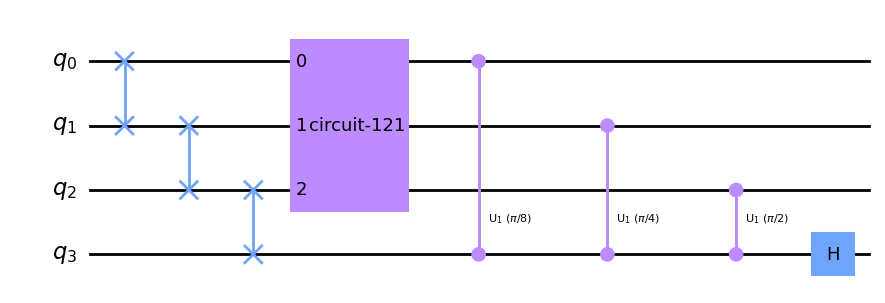

In [10]:
QFT(16).draw(output='mpl')

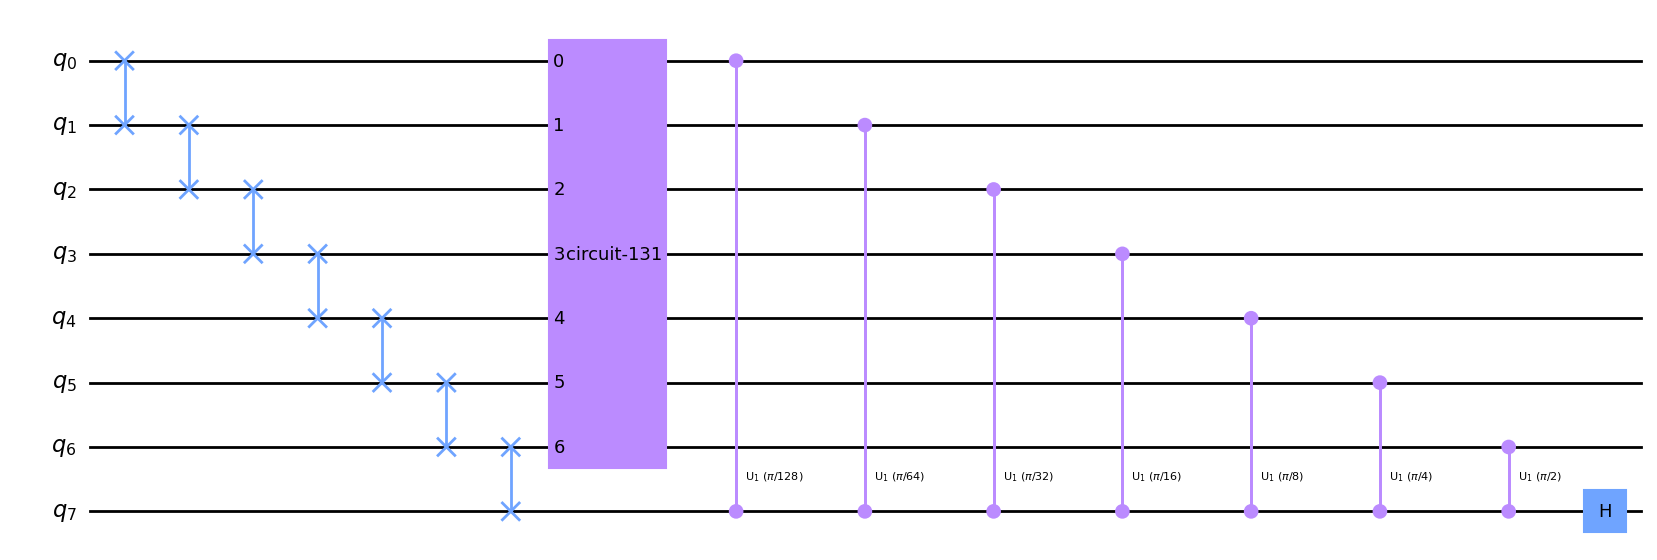

In [11]:
QFT(256).draw(output='mpl')

You can check if the right matrices are computed by checking the value of
```array_to_latex(sqrt(Q)*qi.Operator(QFT(Q)))``` for different values of $Q=2^q$.

In [12]:
array_to_latex(2*qi.Operator(QFT(4)))

<IPython.core.display.Latex object>

In [13]:
array_to_latex(2*sqrt(2)*qi.Operator(QFT(8)))

<IPython.core.display.Latex object>

## Oracle and test
To check that QFT is working properly, let us compute the period of some modular power function.

Unfortunately, factoring even $15=3\cdot 5$ needs $Q=256$, and that in turn needs $q=8$ qubits for input of the oracle function (and $8$ additional qubits for output). The oracle would then be a $16$ qubit unitary, that is a $65536\times 65536$ matrix. This can make things very lengthy...

Instead, let us compute the Quantum Fourier Transform of the function $f(k)=3^k \mod 7$, so that $N=7$. You can use the modular power function ```pow(3,k,7)``` and build the XOR oracle associated to it (in a similar way of what we did for Simon's algorithm oracle).

The size in the oracle in this case comes from $Q=64>49=7^2$, so that $q=6$.

In [14]:
def ket_reg(n,x):
    if x < 0 or x > 2**n-1:
        return(-1)
    output = [[0] for i in range(x)]+[[1]]+ [[0] for i in range(2**n-x-1)]
    return(np.int8(np.matrix(output)))

def bra_reg(n,x):
    return(np.int8(ket_reg(n,x).H))

def Shor_Oracle(x,N):
    q = int(2*np.log(N)/np.log(2))+1
    # print("You will need "+str(q)+" qubits")
    unitary = np.zeros((4**q,4**q),dtype=np.int8)
    for i in range(2**q):
        for j in range(2**q):
           unitary += np.kron(ket_reg(q, j ^ pow(3, i ,7)), ket_reg(q, i)) @ np.kron(bra_reg(q, j), bra_reg(q, i))
    return(UnitaryGate(unitary,label='U_f'))
    

In [15]:
Shor_Gate = Shor_Oracle(3,7)

Use the ```Shor_Gate``` oracle to build a ```Shor``` circuit (you will need 12 qubits) that:
- Does a total superposition of the "input" qubits
- applies the oracle
- applies the QFT to the "input" qubits
- and measures them

In [16]:
q = 6

def Shor(q):
    qc = QuantumCircuit(0, 0)
    qub = []
    cr = ClassicalRegister(q, "res")
    qc.add_register(cr)
    
    for i in range(0, 2 * q):
        qi = QuantumRegister(1, i)
        qub.append(qi)
        qc.add_register(qub[i])
    
    qc.barrier()
    
    for i in range(len(qub)) :
        qc.h(qub[i])
        
    qc.barrier()
    
    qc.append(Shor_Oracle(3,7), qub)
    
    qc.barrier()

    qc.append(QFT(2**q), list(range(q)))

    qc.barrier()
    
    for i in range(len(qub)) :
        qc.h(qub[i])

    qc.measure(list(range(q)), cr)  
    
    return qc


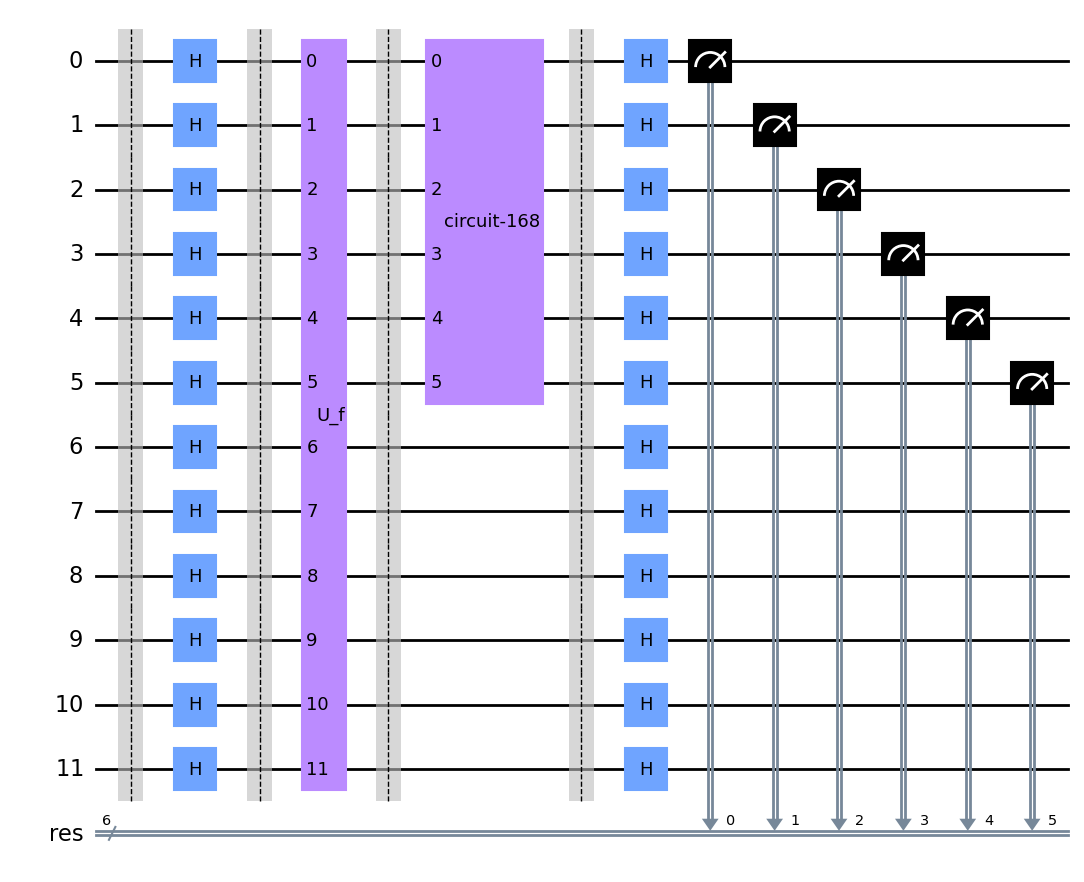

In [17]:
# q = 6
# qc = QuantumCircuit(0, 0)
# qub = []
# cr = ClassicalRegister(q, "res")
# qc.add_register(cr)

# for i in range(0, 2 * q):
#     qi = QuantumRegister(1, i)
#     qub.append(qi)
#     qc.add_register(qub[i])
    
# qc.barrier()

# for i in range(len(qub)) :
#     qc.h(qub[i])
        
# qc.barrier()
    
# # qc.append(Shor_Oracle(3,7), qub)

# qc.barrier()

# qc.append(QFT(2**q), list(range(q)))

# qc.barrier()
    
# for i in range(len(qub)) :
#     qc.h(qub[i])

# qc.measure(list(range(q)), cr)  



# qc.draw(output='mpl')

Shor(6).draw(output='mpl')
# the circuit used in the shor's algorithm

Let us get a histogram of the circuit. Can you compute the period of our modular power function?

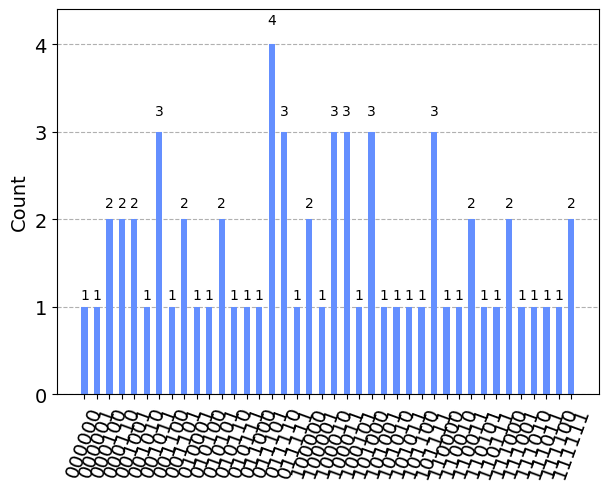

In [18]:
aer_sim = Aer.get_backend('aer_simulator')

result = execute(Shor(6), aer_sim,shots=64).result()
statistics = result.get_counts()
plot_histogram(statistics)
# the highest values from the histogram corespond to the k values that are suitable for the continuous fraction expansion
# in order tp find out the perios ss ( Q/k = C/s)